In [1]:
from __future__ import annotations
from typing import Union, Literal
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import urllib.request as url
import pytz
import os
from IPython.display import display as ipdisplay
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

import sys
sys.path.append('..')
from data_processing.data_import import Elmy_import, test_equal
from visualization.visualize import visualize_nan
from interpolation.low_rank_interpolation import low_rank_interpolation
from interpolation.auto_regressive_interpolation import ar_interpolation_multiple_nan_seq, ar_interpolation
from detrending.polynomial_detrending import polynomial_detrending
from prediction.helper_func import get_lstm_data, get_lstm_data_from_X_train_X_test, plot_loss_and_metrics, weighted_accuracy, get_lstm_data_from_X_train_X_test_no_shuffle
from prediction.lstm_tensorflow import train_lstm, lstm_model
from prediction.lstm_pytorch import train_LSTM_classification, train_LSTM_regression, LSTMPyTorch, inference_train_regression, inference_test_regression, inference_train_classification, inference_test_classification

# Import the data

In [2]:
X_train_clean_inter_scaled = Elmy_import('../data/processed/X_train_full_clean_ar_interp_scaled.csv', with_date=False)
y_train_raw = Elmy_import('../data/raw/y_train.csv', target=True)
X_test_clean_inter_2_scaled = Elmy_import('../data/processed/X_test_full_clean_ar_interp_2_scaled.csv', with_date=False)
X_train_clean = Elmy_import('../data/processed/X_train_full_clean.csv', with_date=False)
X_test_clean = Elmy_import('../data/processed/X_test_full_clean.csv', with_date=False)
y_random_raw = Elmy_import('../data/raw/y_random.csv', target=True)

# ``NaN`` values

In [3]:
# number of NaN per column
ipdisplay(pd.concat([X_train_clean_inter_scaled.isna().sum(), X_train_clean.isna().sum(), X_test_clean_inter_2_scaled.isna().sum(), X_test_clean.isna().sum()], axis=1, keys=['X_train_clean_inter_scaled', 'X_train_clean', 'X_test_clean_inter_2_scaled', 'X_test_clean']))

,X_train_clean_inter_scaled,X_train_clean,X_test_clean_inter_2_scaled,X_test_clean
predicted_spot_price,0.0,8759,0.0,1536
TMin (°C),0.0,0,0.0,0
TMax (°C),0.0,0,0.0,0
Température référence (°C),0.0,0,0.0,0
Pic journalier consommation (MW),0.0,0,0.0,0
Solde max (MW),0.0,0,0.0,0
Solde min (MW),0.0,0,0.0,0
TMoy (°C),0.0,0,0.0,0
wind_power_forecasts_average,0.0,0,0.0,0
solar_power_forecasts_average,0.0,0,0.0,0


# Visualization

C:\Users\Tim\AppData\Local\Temp\ipykernel_1600\3207536775.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  X_train_clean_inter_scaled.index = pd.to_datetime(X_train_clean_inter_scaled.index)


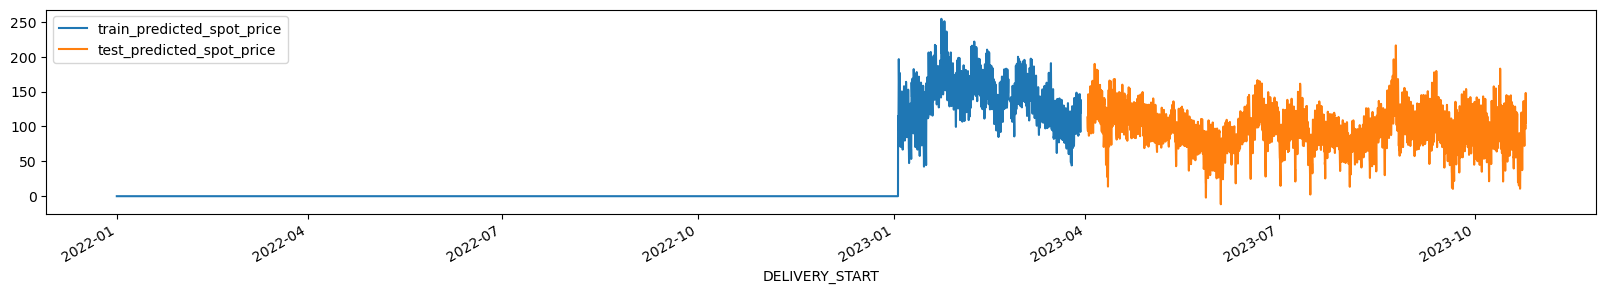

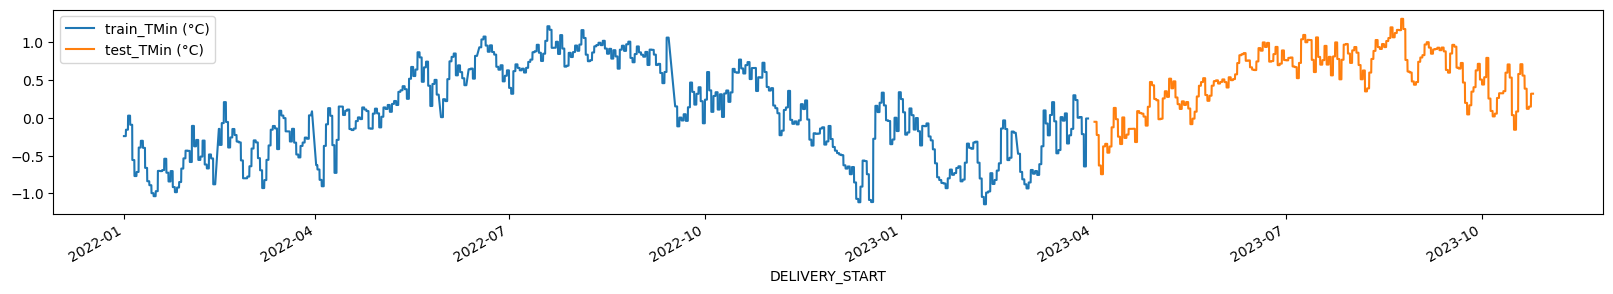

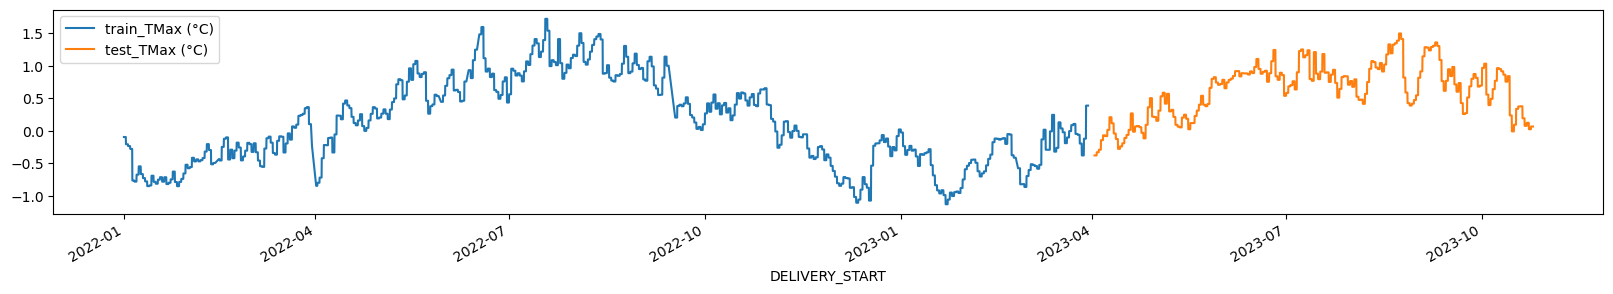

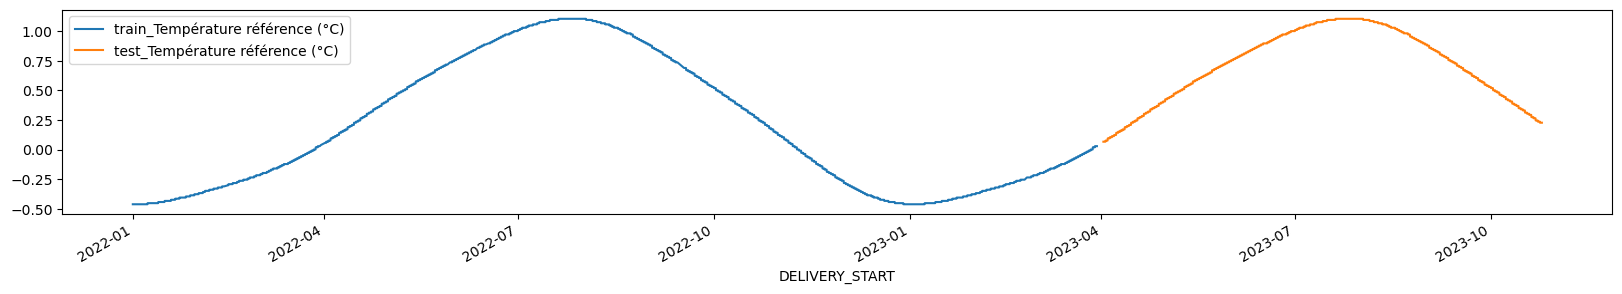

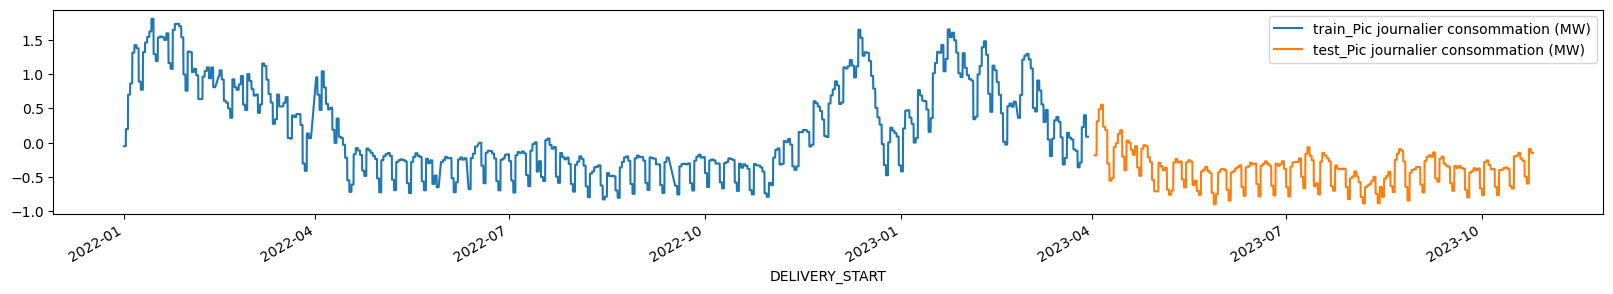

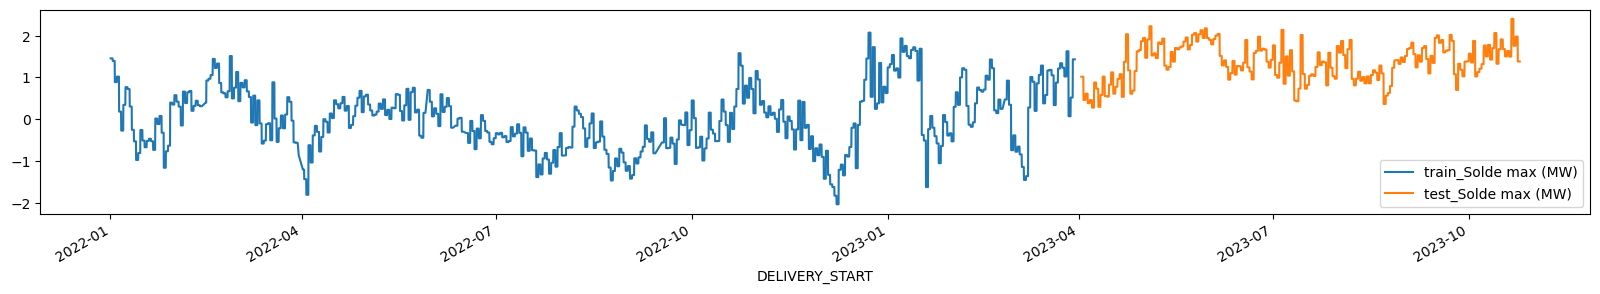

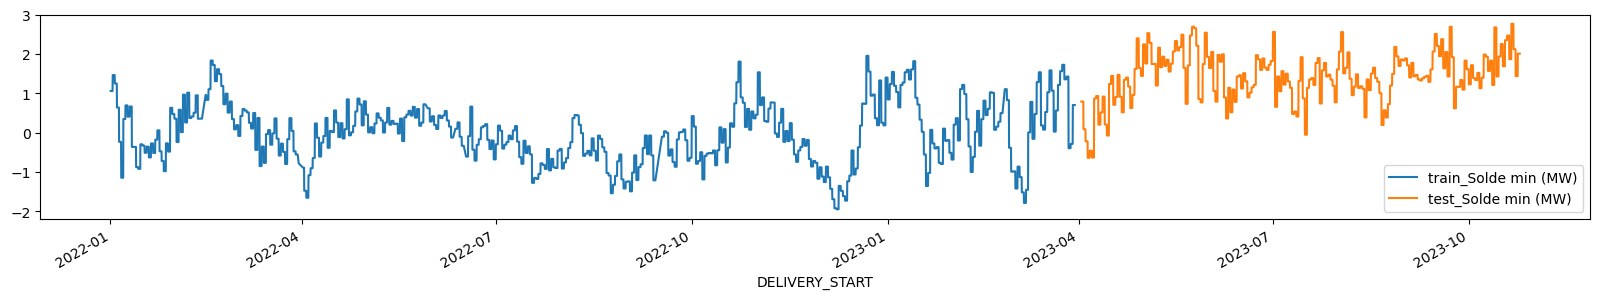

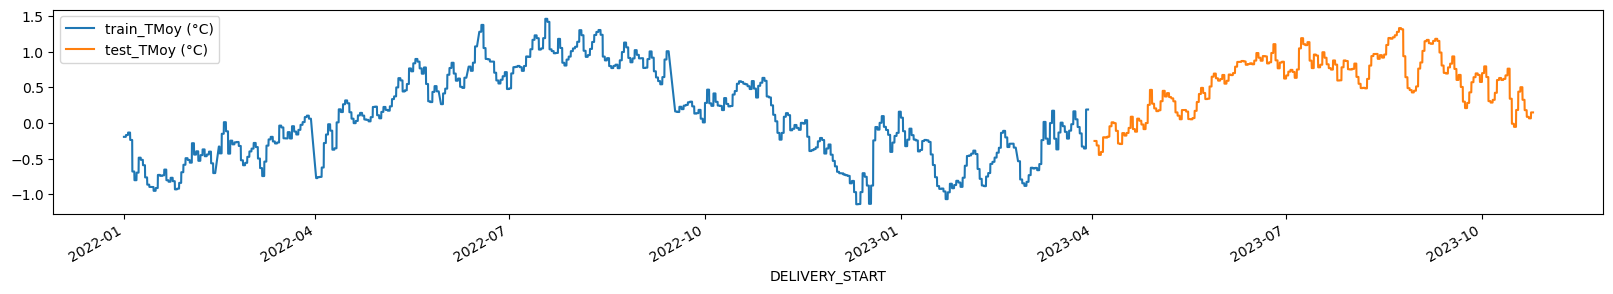

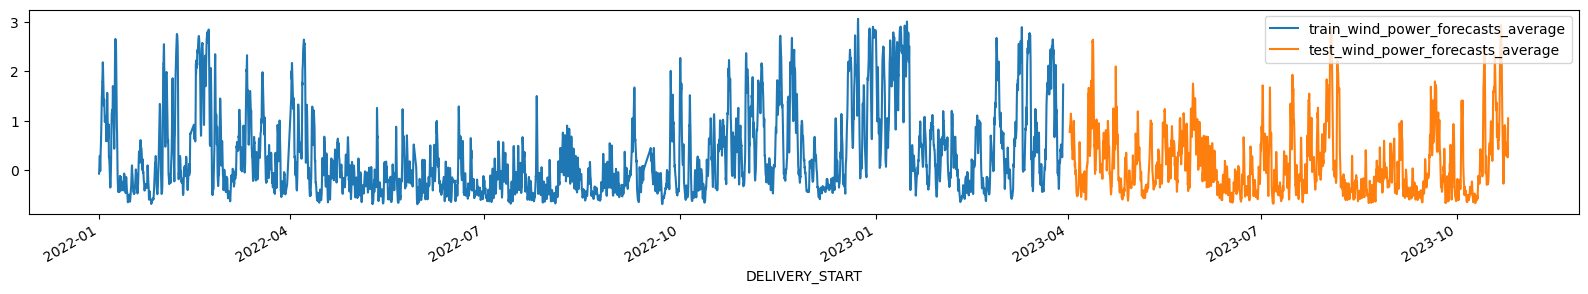

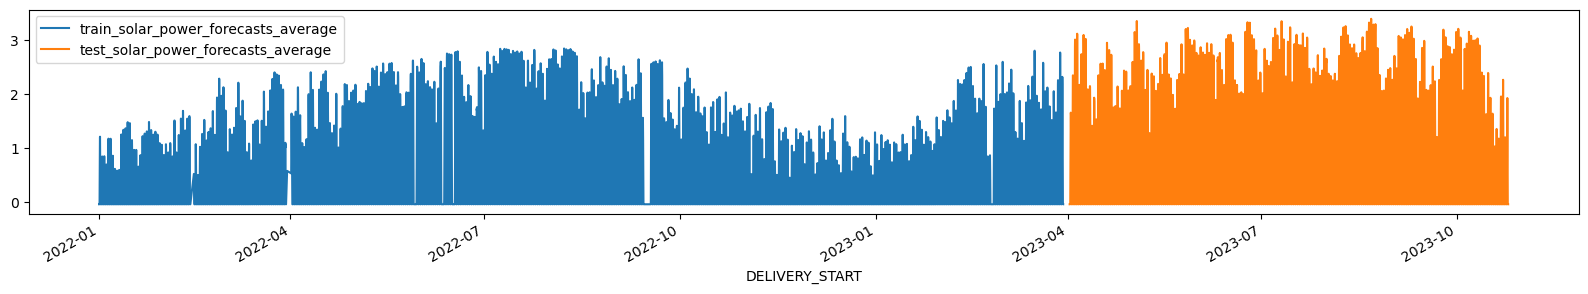

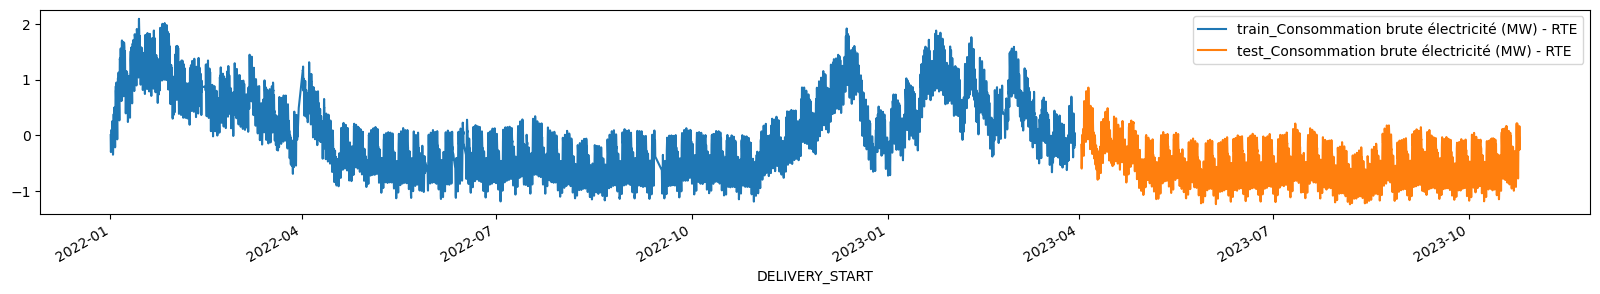

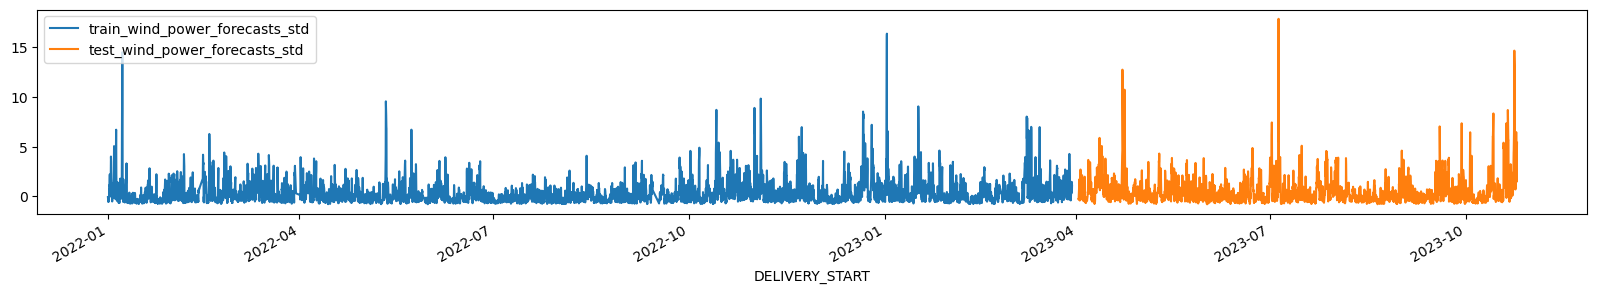

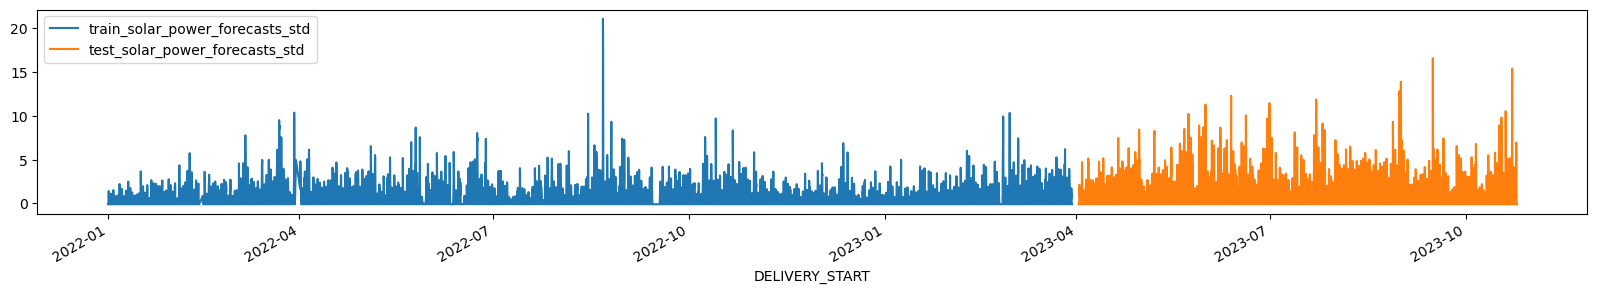

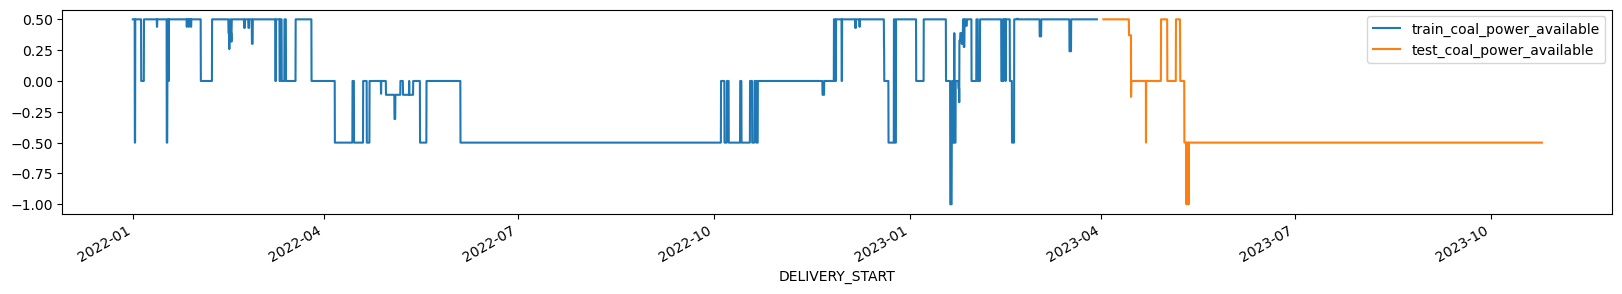

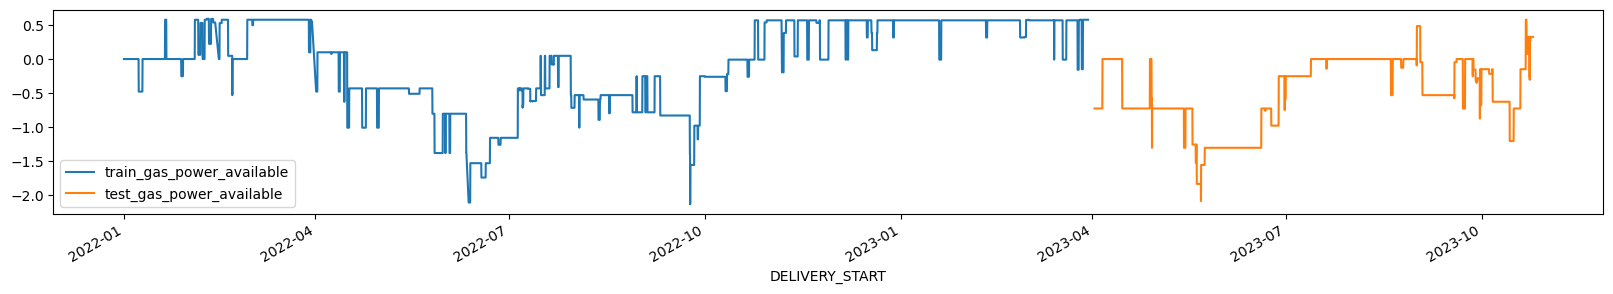

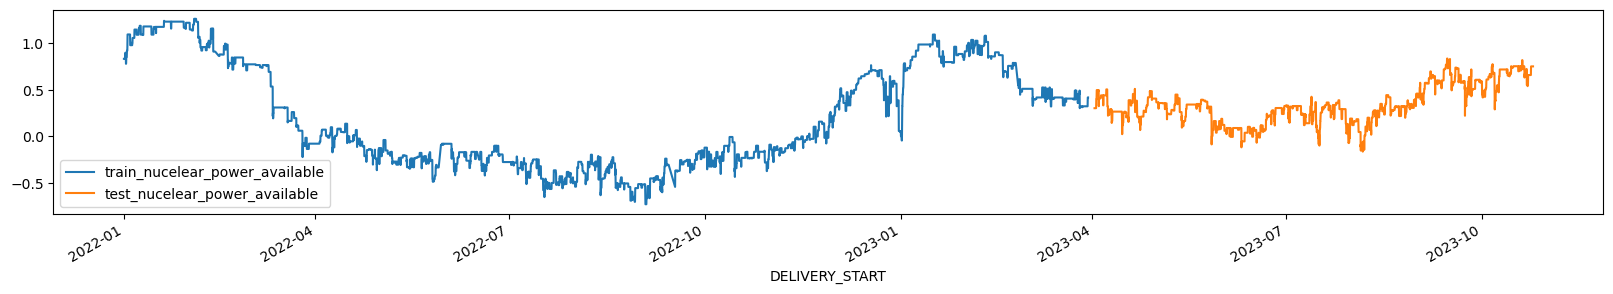

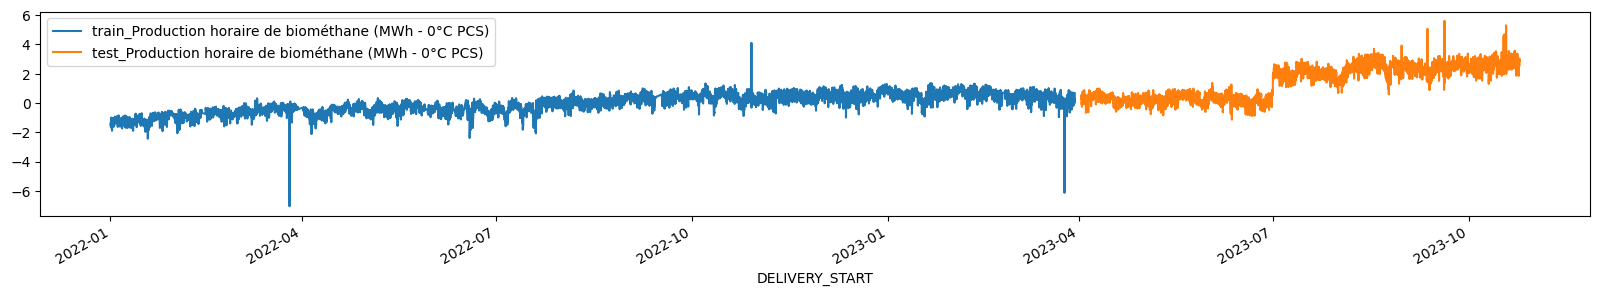

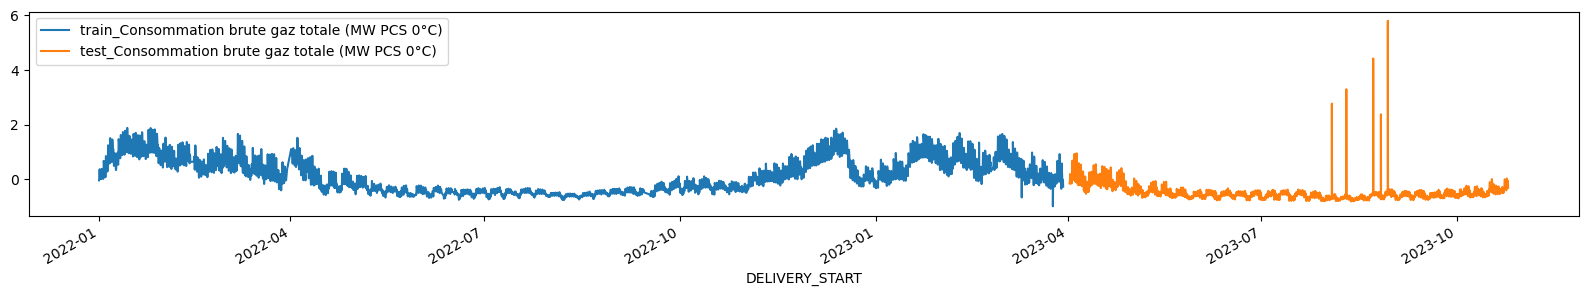

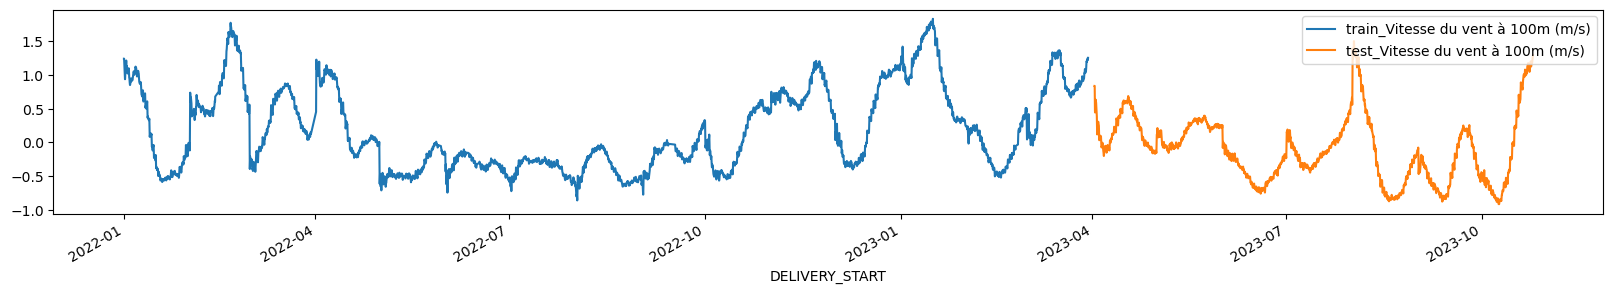

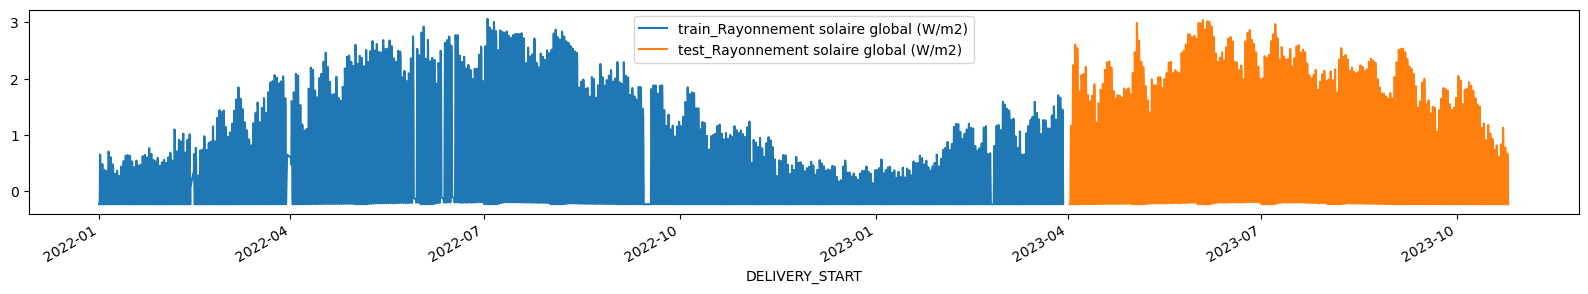

In [5]:
if not(isinstance(X_train_clean_inter_scaled.index[0], pd.Timestamp)):
    X_train_clean_inter_scaled.index = pd.to_datetime(X_train_clean_inter_scaled.index)
    X_test_clean_inter_2_scaled.index = pd.to_datetime(X_test_clean_inter_2_scaled.index)
for col in X_test_clean_inter_2_scaled.columns:
    plt.figure(figsize=(20, 3))
    X_train_clean_inter_scaled[col].plot(label=f'train_{col}')
    X_test_clean_inter_2_scaled[col].plot(label=f'test_{col}')
    plt.legend()
    plt.show()

# lightgbm classifier

In [74]:
X_train_clean_inter_scaled.drop('predicted_spot_price', axis=1, inplace=True)
X_test_clean_inter_2_scaled.drop('predicted_spot_price', axis=1, inplace=True)

In [75]:
y_train_raw_new = 2 * (y_train_raw>=0.0).astype(int) - 1
y_train_raw_new

,spot_id_delta
DELIVERY_START,
2022-01-01 02:00:00+01:00,-1
2022-01-01 03:00:00+01:00,-1
2022-01-01 04:00:00+01:00,-1
2022-01-01 05:00:00+01:00,1
2022-01-01 06:00:00+01:00,1
...,...
2023-03-29 19:00:00+02:00,1
2023-03-29 20:00:00+02:00,1
2023-03-29 21:00:00+02:00,1


In [76]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_clean_inter_scaled.values, y_train_raw_new.values, test_size=0.1, random_state=42)

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
}

# Train LightGBM model
num_round = 1000
lgbClassifer = lgb.train(params, train_data, num_round, valid_sets=[test_data])

c:\Users\Tim\anaconda3\envs\python39\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Number of positive: 4776, number of negative: 4768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 9544, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500419 -> initscore=0.001676
[LightGBM] [Info] Start training from score 0.001676


In [77]:
(y_train_raw_new==1).sum() * 0.9

spot_id_delta    4788.0
dtype: float64

In [107]:
threshold = 0.03
y_pred = lgbClassifer.predict(X_test_clean_inter_2_scaled.values)
y_pred_bis = 2 * (y_pred >= threshold) - 1
print(np.sum(y_pred_bis==-1), np.sum(y_pred_bis==1))
print(f'{np.sum(y_pred_bis==1)/len(y_pred_bis)*100:.2f}%')
print((y_train_raw_new==1).mean())

1373 3569
72.22%
spot_id_delta    0.50165
dtype: float64


In [100]:
y_random_raw = Elmy_import('../data/raw/y_random.csv', target=True)

In [108]:
pd.DataFrame(y_pred_bis, columns=y_random_raw.columns, index=y_random_raw.index).to_csv('../data/processed/y_lbg_3.csv')

# LSTM Classifier

In [6]:
y_train = (y_train_raw < 0).astype(int)
y_train = pd.concat((y_train, 1-y_train), axis=1)
y_train.columns = ['neg_delta', 'pos_delta']
y_train

,neg_delta,pos_delta
DELIVERY_START,,
2022-01-01 02:00:00+01:00,1,0
2022-01-01 03:00:00+01:00,1,0
2022-01-01 04:00:00+01:00,1,0
2022-01-01 05:00:00+01:00,0,1
2022-01-01 06:00:00+01:00,0,1
...,...,...
2023-03-29 19:00:00+02:00,0,1
2023-03-29 20:00:00+02:00,0,1
2023-03-29 21:00:00+02:00,0,1


In [14]:
sequence_length = 15
epochs = 100
batch_size = 10
hidden_sizes=[15, 10]
dropout = 0.02
lr = 0.01
l2reg = 1e-4
train_size = 0.8
n_classes = 2
train_val_weights = y_train_raw.values[-len(y_train_raw) + sequence_length:, 0]

X_train_val_lstm, y_train_val_lstm, X_test_lstm, y_test_lstm = get_lstm_data_from_X_train_X_test_no_shuffle(X_train_clean_inter_scaled.values, y_train.values, X_test_clean_inter_2_scaled.values, None, sequence_length)
lstm = LSTMPyTorch(n_input=X_train_clean_inter_scaled.shape[1], n_output=n_classes, hidden_sizes=hidden_sizes, dropout=dropout)
lstm, history = train_LSTM_classification(lstm, X_train_val_lstm, y_train_val_lstm, train_size, 'binary_crossentropy_with_logits', 'adam', epochs, batch_size, metrics=['accuracy', 'weighted_accuracy'], lr=lr, weight_decay=l2reg, train_val_weights=train_val_weights)

Epoch 0001/100 - loss 0.688 - val_loss 0.686 - accuracy 0.550 - val_accuracy 0.544 - weighted_accuracy 0.572 - val_weighted_accuracy 0.565
Epoch 0002/100 - loss 0.683 - val_loss 0.680 - accuracy 0.561 - val_accuracy 0.559 - weighted_accuracy 0.587 - val_weighted_accuracy 0.585
Epoch 0003/100 - loss 0.674 - val_loss 0.678 - accuracy 0.574 - val_accuracy 0.555 - weighted_accuracy 0.595 - val_weighted_accuracy 0.586
Epoch 0004/100 - loss 0.669 - val_loss 0.681 - accuracy 0.593 - val_accuracy 0.578 - weighted_accuracy 0.630 - val_weighted_accuracy 0.594
Epoch 0005/100 - loss 0.660 - val_loss 0.675 - accuracy 0.608 - val_accuracy 0.591 - weighted_accuracy 0.652 - val_weighted_accuracy 0.646
Epoch 0006/100 - loss 0.657 - val_loss 0.670 - accuracy 0.614 - val_accuracy 0.594 - weighted_accuracy 0.668 - val_weighted_accuracy 0.642
Epoch 0007/100 - loss 0.652 - val_loss 0.666 - accuracy 0.612 - val_accuracy 0.594 - weighted_accuracy 0.671 - val_weighted_accuracy 0.646
Epoch 0008/100 - loss 0.646

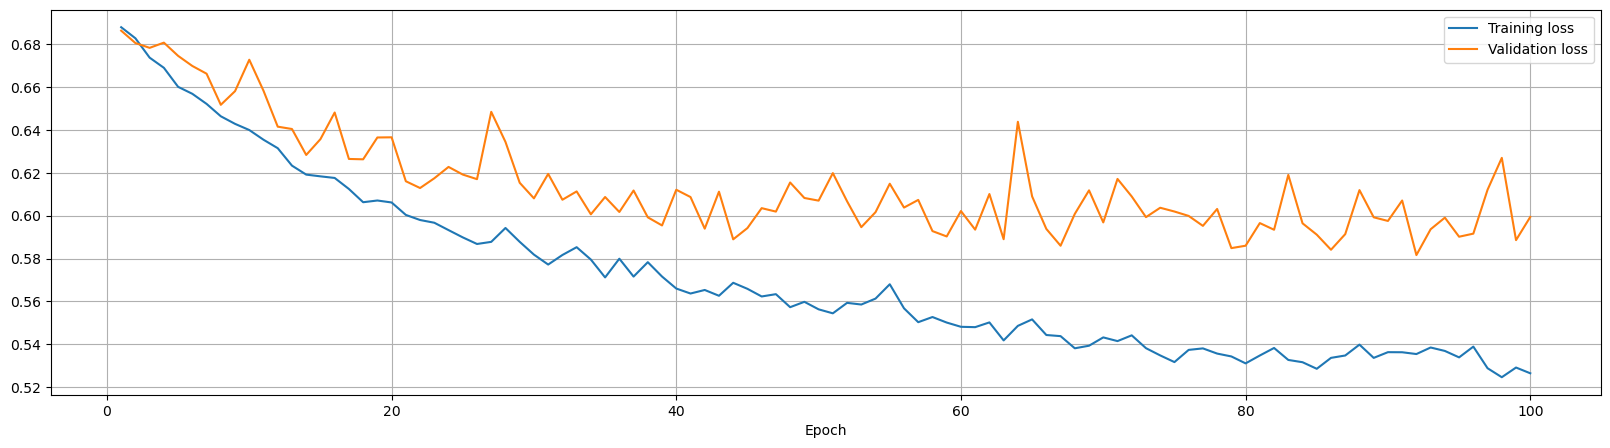

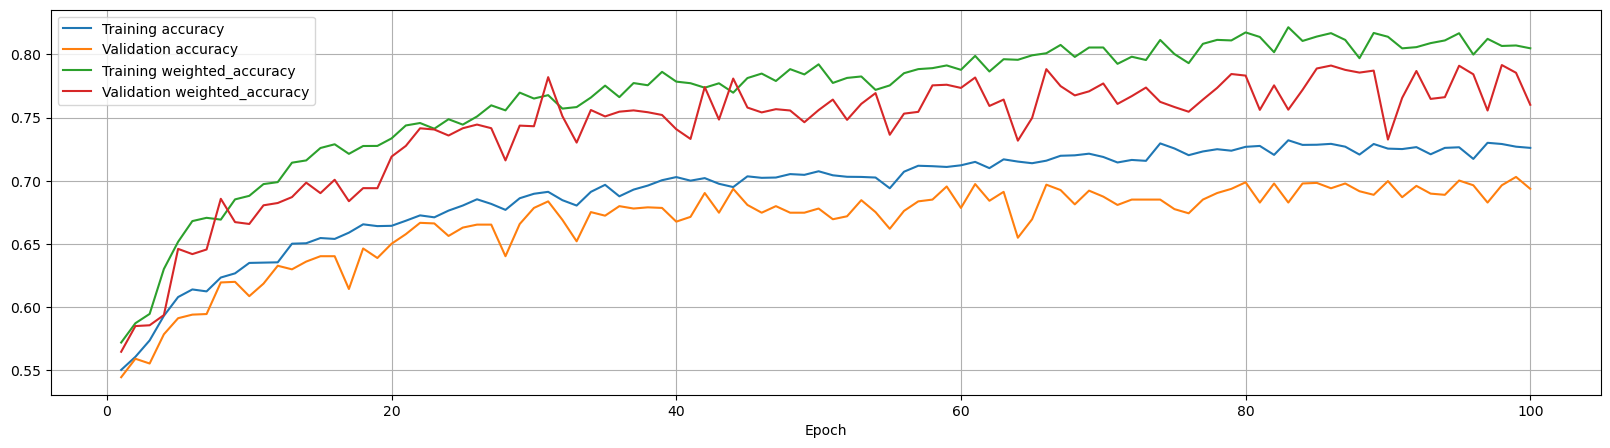

In [15]:
plot_loss_and_metrics(history, epochs, names=['loss'])
plot_loss_and_metrics(history, epochs, names=['accuracy', 'weighted_accuracy'])

In [50]:
dl = 30
with torch.no_grad():
    y_hat_train = inference_train_classification(lstm, X_train_val_lstm, y_train.index, sequence_length)
    y_hat_test = inference_test_classification(lstm, X_test_lstm, y_random_raw.index)
    print(f"{'-'*dl} Training {'-'*dl}")
    print(f'Accuracy {accuracy_score(y_train.iloc[-len(y_train) + sequence_length:, 1], y_hat_train):.2f} - Weighted accuracy {weighted_accuracy(y_train_raw.iloc[-len(y_train) + sequence_length:, 0],  y_hat_train):.2f}')
    print(f"Percentage of positive class: {(y_hat_train==1).mean()*100:.2f}%")
    print(f"Percentage of negative class: {(y_hat_train==0).mean()*100:.2f}%")
    print(f"\n{'-'*dl} Test {'-'*dl}")
    y_hat_test.replace(0, -1, inplace=True)
    print(f"Percentage of positive class: {(y_hat_test==1).mean()*100:.2f}%")
    print(f"Percentage of negative class: {(y_hat_test==-1).mean()*100:.2f}%")
    y_hat_test = pd.DataFrame(y_hat_test.values, index=y_random_raw.index, columns=y_random_raw.columns)

------------------------------ Training ------------------------------
Accuracy 0.73 - Weighted accuracy 0.70
Percentage of positive class: 57.57%
Percentage of negative class: 42.43%

------------------------------ Test ------------------------------
Percentage of positive class: 83.10%
Percentage of negative class: 16.90%


In [39]:
y_hat_test.to_csv('../data/processed/y_lstm_pytorch.csv')

# LSTM Regressor

Epoch 0001/50 - loss 1552.902 - val_loss 1019.245 - accuracy 0.539 - val_accuracy 0.562 - weighted_accuracy 0.550 - val_weighted_accuracy 0.602
Epoch 0002/50 - loss 1547.694 - val_loss 1008.213 - accuracy 0.545 - val_accuracy 0.569 - weighted_accuracy 0.570 - val_weighted_accuracy 0.601
Epoch 0003/50 - loss 1544.361 - val_loss 1008.065 - accuracy 0.552 - val_accuracy 0.556 - weighted_accuracy 0.582 - val_weighted_accuracy 0.617
Epoch 0004/50 - loss 1523.456 - val_loss 990.448 - accuracy 0.576 - val_accuracy 0.585 - weighted_accuracy 0.623 - val_weighted_accuracy 0.645
Epoch 0005/50 - loss 1510.225 - val_loss 987.241 - accuracy 0.580 - val_accuracy 0.594 - weighted_accuracy 0.630 - val_weighted_accuracy 0.638
Epoch 0006/50 - loss 1504.455 - val_loss 967.106 - accuracy 0.595 - val_accuracy 0.589 - weighted_accuracy 0.641 - val_weighted_accuracy 0.661
Epoch 0007/50 - loss 1494.226 - val_loss 965.919 - accuracy 0.598 - val_accuracy 0.600 - weighted_accuracy 0.652 - val_weighted_accuracy 0.

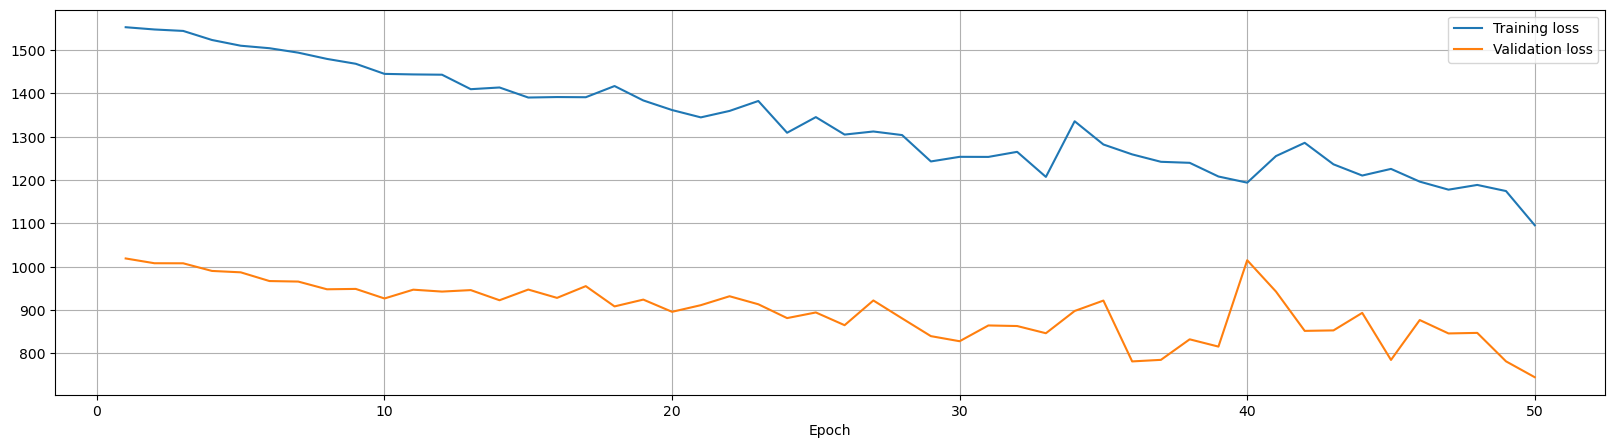

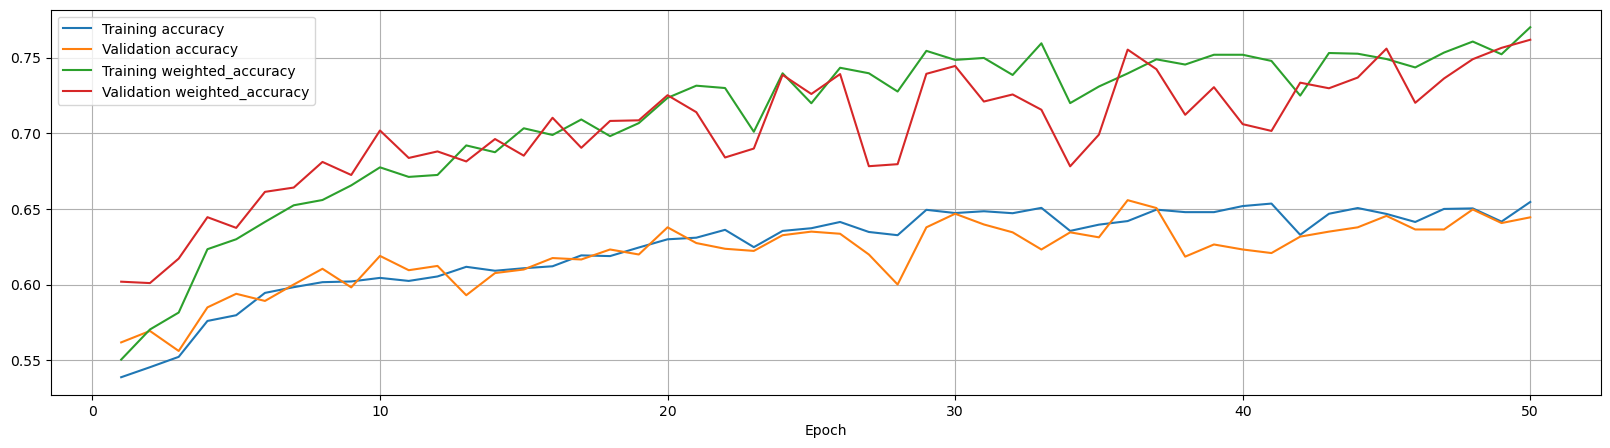

In [3]:
loss = 'mean_squared_error'
lr = 0.01
weight_decay = 1e-4
hidden_sizes = [15, 10]
sequence_length = 15
dropout = 0.02
train_size = 0.8
epochs = 15
batch_size = 10
y_train = y_train_raw
train_val_weights = y_train_raw.values[-len(y_train_raw) + sequence_length:, 0]

X_train_val_lstm, y_train_val_lstm, X_test_lstm, y_test_lstm = get_lstm_data_from_X_train_X_test_no_shuffle(X_train_clean_inter_scaled.values, y_train.values, X_test_clean_inter_2_scaled.values, None, sequence_length)
lstm = LSTMPyTorch(n_input=X_train_clean_inter_scaled.shape[1], n_output=1, hidden_sizes=hidden_sizes, dropout=dropout)
lstm, history = train_LSTM_regression(lstm, X_train_val_lstm, y_train_val_lstm, train_size, loss, 'adam', epochs, batch_size, ['accuracy', 'weighted_accuracy'], lr, weight_decay, train_val_weights)

plot_loss_and_metrics(history, epochs, names=['loss'])
plot_loss_and_metrics(history, epochs, names=['accuracy', 'weighted_accuracy']) 

In [26]:
scaled_threshold = 0.0
target_percentile = 60.3

with torch.no_grad():
    temp = 30
    y_hat_train = inference_train_regression(lstm, X_train_val_lstm, y_train.index, sequence_length)
    y_hat_test = inference_test_regression(lstm, X_test_lstm, y_random_raw.index)
    
    weights = y_train_raw.values[-len(y_train_raw) + sequence_length:, 0]
    abs_weights = np.abs(weights)
    pos_class = (weights > scaled_threshold).astype(float)
    pred_pos_class = (y_hat_train.values > scaled_threshold).astype(float)
    true_mask = pos_class==pred_pos_class
    weighted_acc = abs_weights[true_mask]
    print(f"{'-'*temp} Training {'-'*temp}")
    print(f'Accuracy {accuracy_score(pos_class, pred_pos_class):.2f} {np.sum(true_mask) / len(true_mask):.2f} - Weighted accuracy {np.sum(weighted_acc) / np.sum(abs_weights):.2f}')
    neg_class = (weights < scaled_threshold).astype(float)
    pred_neg_class = (y_hat_train.values < scaled_threshold).astype(float)
    print(f"Percentage of positive class: {pred_pos_class.mean()*100:.2f}% - True Percentage {pos_class.mean()*100:.2f}% - True full percentage {(y_train_raw.values>scaled_threshold).mean()*100:.2f}%")
    print(f"Percentage of negative class: {pred_neg_class.mean()*100:.2f}% - True Percentage {neg_class.mean()*100:.2f}% - True full percentage {(y_train_raw.values<scaled_threshold).mean()*100:.2f}%")
    print(f"\n{'-'*temp} Test {'-'*temp}")
    pred_pos_class = (y_hat_test.values > scaled_threshold).astype(float)
    pred_neg_class = (y_hat_test.values < scaled_threshold).astype(float)
    print(f"Percentage of positive class: {pred_pos_class.mean()*100:.2f}%")
    print(f"Percentage of negative class: {pred_neg_class.mean()*100:.2f}%")

    print(f"\n{'-'*temp} Test after applying the target percentile {'-'*temp}")
    new_thr = np.percentile(y_hat_test.values, 100 - target_percentile)
    pred_pos_class = (y_hat_test.values > new_thr).astype(float)
    pred_neg_class = (y_hat_test.values < new_thr).astype(float)
    non_def_class = (y_hat_test.values == new_thr).astype(float)
    print(f"Percentage of positive class: {pred_pos_class.mean()*100:.2f}%")
    print(f"Percentage of negative class: {pred_neg_class.mean()*100:.2f}%")
    print(f"Percentage of non-definite class: {non_def_class.mean()*100:.2f}% (will be assigned to positive)")

    y_hat_test = pd.DataFrame(2 * (y_hat_test.values >= new_thr).astype(float) - 1.0, index=y_random_raw.index, columns=y_random_raw.columns).replace(0.0, -1.0)


------------------------------ Training ------------------------------
Accuracy 0.66 0.66 - Weighted accuracy 0.78
Percentage of positive class: 55.34% - True Percentage 50.22% - True full percentage 50.17%
Percentage of negative class: 44.66% - True Percentage 49.78% - True full percentage 49.83%

------------------------------ Test ------------------------------
Percentage of positive class: 98.56%
Percentage of negative class: 1.44%

------------------------------ Test after applying the target percentile ------------------------------
Percentage of positive class: 51.13%
Percentage of negative class: 33.57%
Percentage of non-definite class: 15.30% (will be assigned to positive)
